## Statistics of Tropical Cyclones (TCs) wind fields derived from Synthetic Aperture Radar (SAR) imagery
The dataset consists of 341 files in one global xarray.Dataset stored in .zarr format. Each file contains a SAR acquisition of one TC at one instant time, as well as the computed wind field associated with the satellite signal. Each file also contains additional information, such as the storm name, ID, and category (= category at the time of the acquisition).

The specificity of this dataset (compared to other TC datasets) is its spatial resolution, which reaches 1 km in both x and y directions. The counterpart is its temporal resolution, which is very low: TC images are acquired when the (polar-orbiting) satellite overpasses a TC (and only if the operational chain decided to put the sensor on at this moment), which leads to an irregular sampling in time. 

The goal of the project is to compute some statistical properties about the TCs of the dataset. This includes statistics about:

- GROUP 1: covariance matrix of the wind fields by Saffir-Simpson category;

- GROUP 2: spatial and temporal coverage of the TCs (basins, seasons), mean wind field by Saffir-Simpson category, as well as statistical distribution of some important metrics (Vmax, Rmax, R64, R50, R34);

In [ ]:
### INSTALLATION
!pip install --upgrade tqdm gcsfs zarr dask xarray scipy datetime

In [4]:
from tqdm import tqdm
import gcsfs
import zarr
import dask as da

import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

from scipy.interpolate import griddata
from datetime import datetime

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)

In [5]:
# OPEN DATASET
fs     = gcsfs.GCSFileSystem(project='ds2class-2021', token='anon', access='read_only')
gcsmap = fs.get_mapper("project10_tc_sar/zarr_data/tc_sar_data.zarr")
ds_all = xr.open_zarr(gcsmap)
ds_all

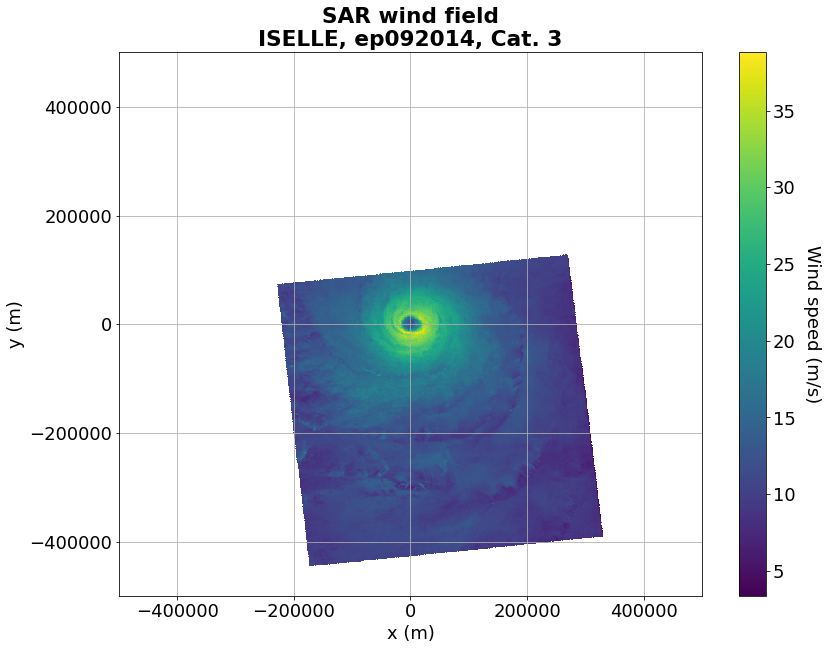

In [11]:
### PLOTTING WIND FIELDS
def plot_wind_field(ds_all, time_idx):
    '''Given an xarray.Dataset object containing all the files (e.g 341) and a time index, plots the corresponding TC wind field using plt.pcolormesh().'''
    # Open figure
    fig, _ = plt.subplots()
    
    # Title
    name = ds_all.isel(time=time_idx)['storm_name'].values
    tcId = ds_all.isel(time=time_idx)['storm_id'].values
    cat  = int(ds_all.isel(time=time_idx)['cat'])
    plt.title('SAR wind field\n%s, %s, Cat. %i'%(name, tcId, cat), weight='bold')
    
    # Plot
    x, y = np.meshgrid(ds_all.isel(time=time_idx)['x'], ds_all.isel(time=time_idx)['y']) # Defining 2D coordinates
    plt.pcolormesh(x, y, ds_all.isel(time=time_idx)['wind_speed'])                       # Plot the wind field
    plt.xlabel('x (m)');plt.ylabel('y (m)');plt.grid()                                   # Add axis legend
    plt.subplots_adjust(right=0.8)                                                       # Colorbar - line 1
    cbar = plt.colorbar()                                                                # Colorbar - line 2
    cbar.set_label('Wind speed (m/s)', rotation=270);cbar.ax.get_yaxis().labelpad=25     # Colorbar - line 3
    
plot_wind_field(ds_all, time_idx=9)

Indexes for HECTOR:  [  0  85  86  87 154 155 269 270]


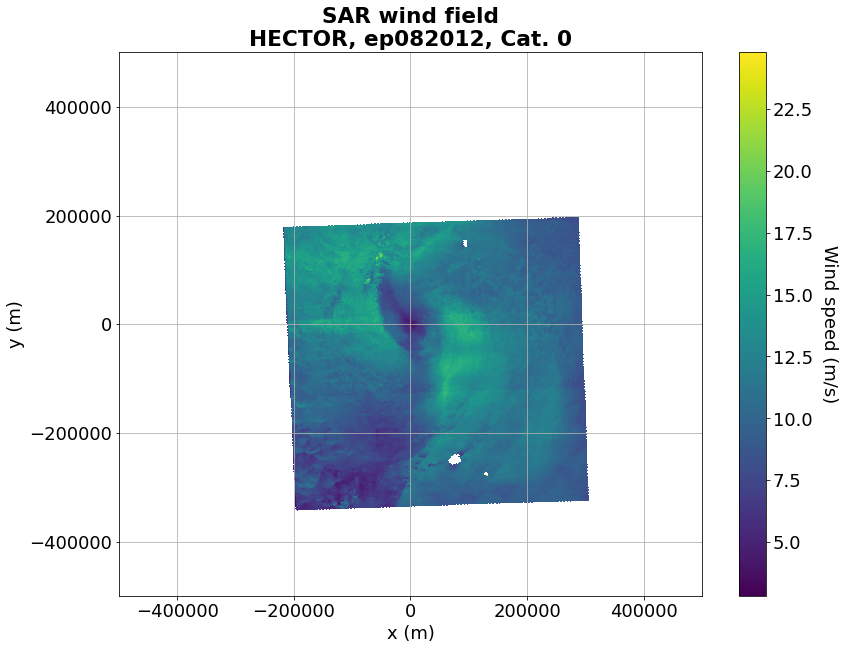

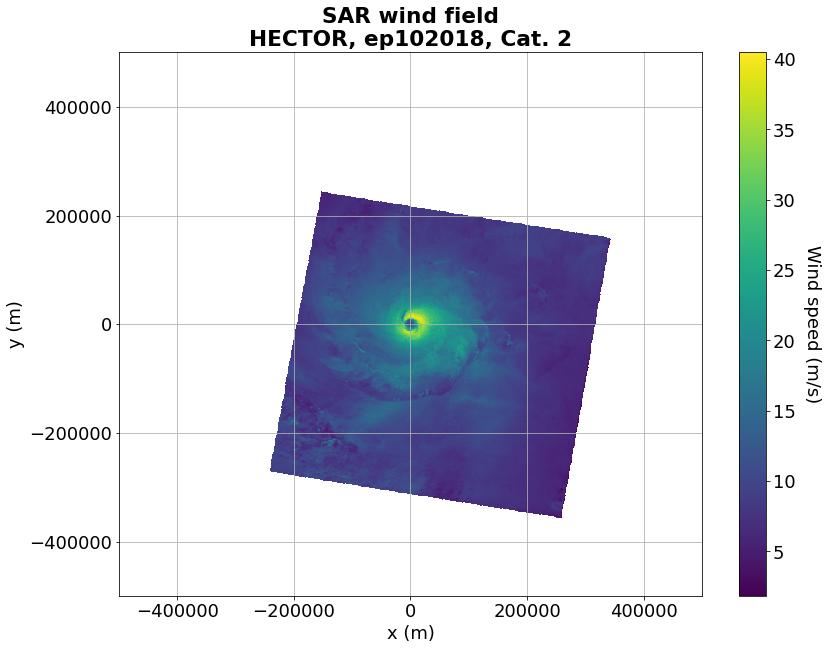

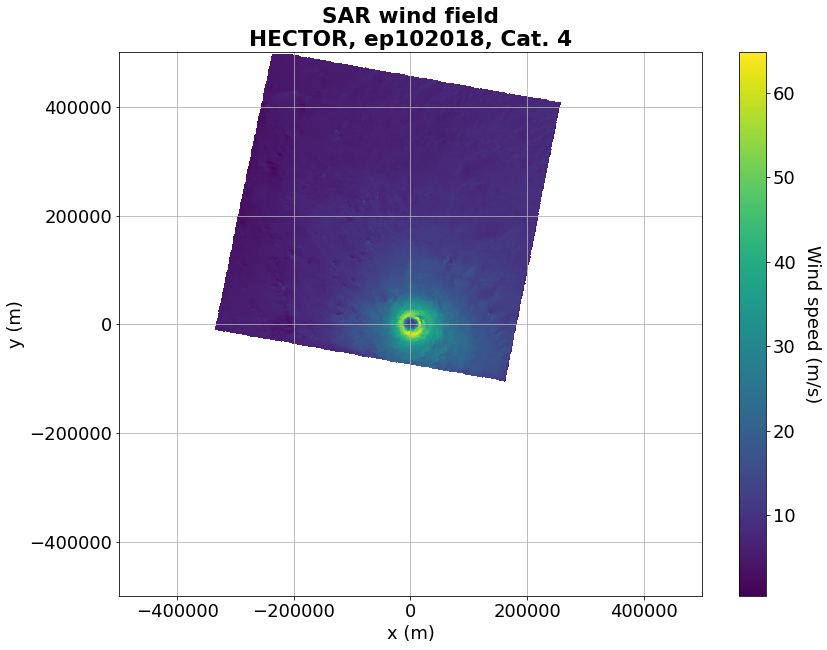

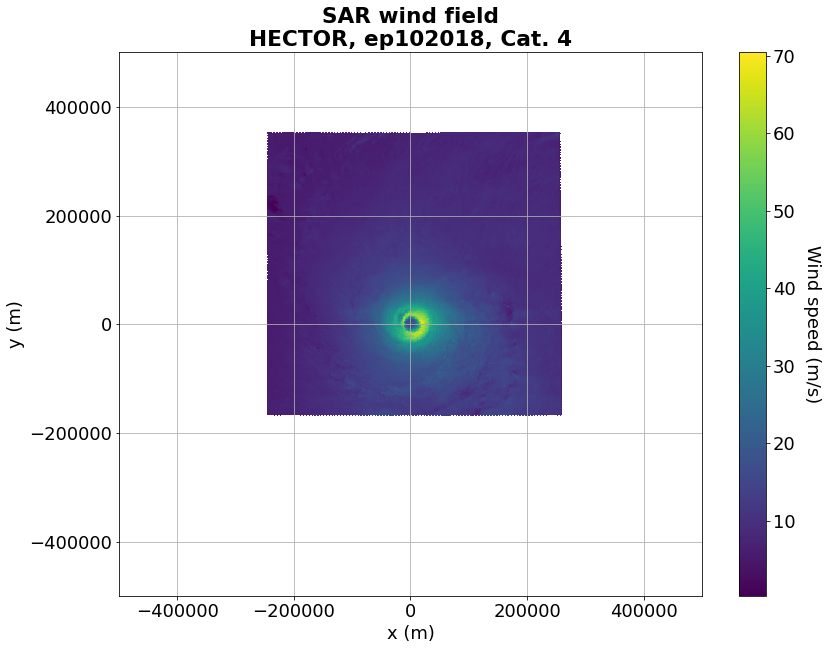

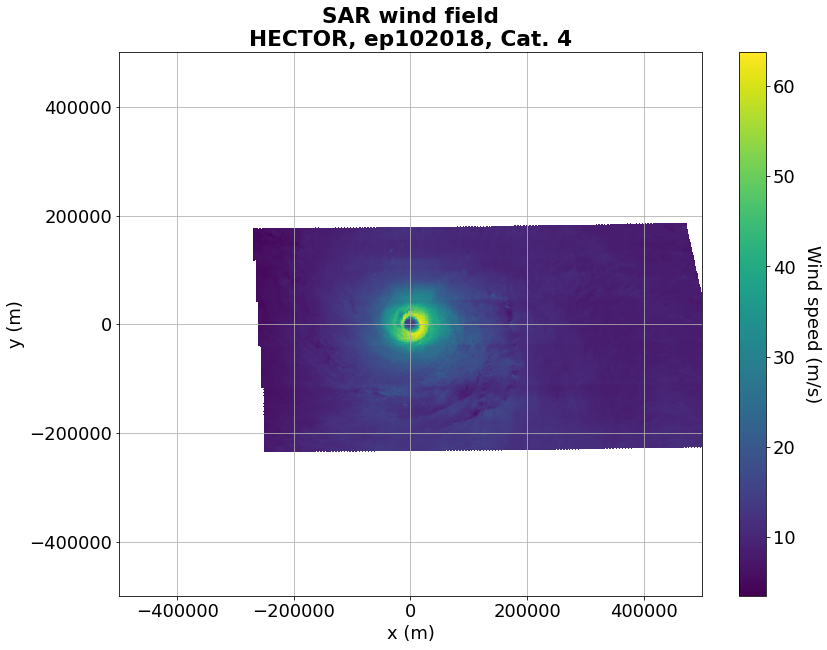

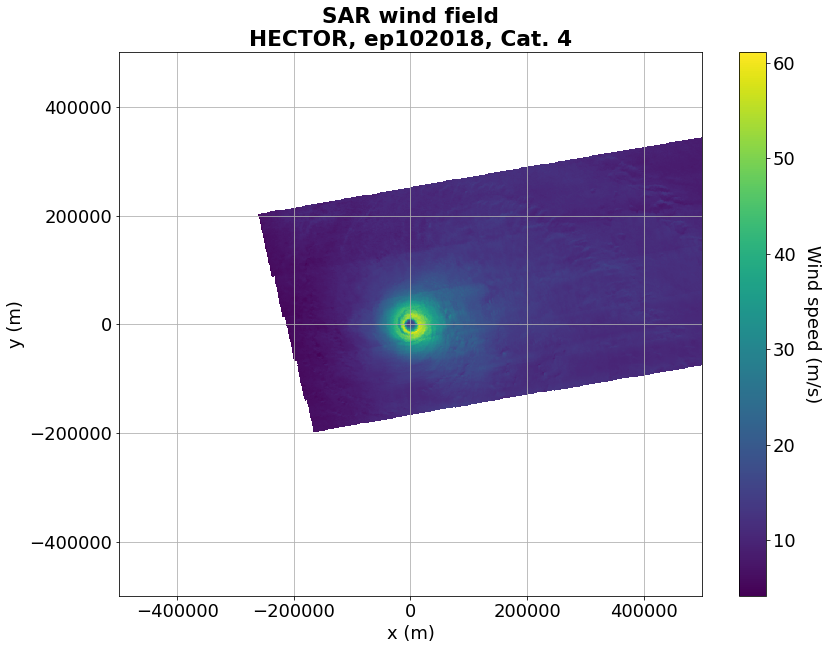

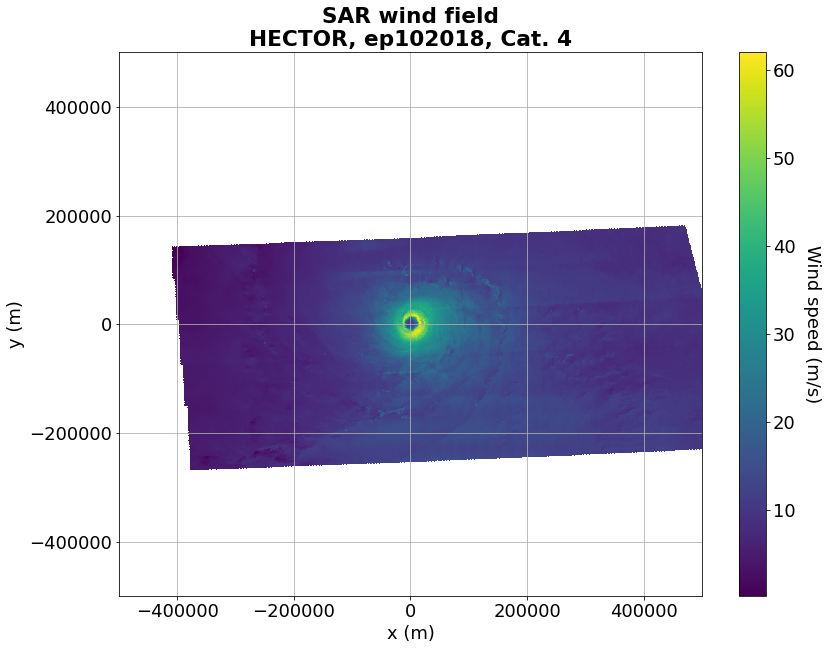

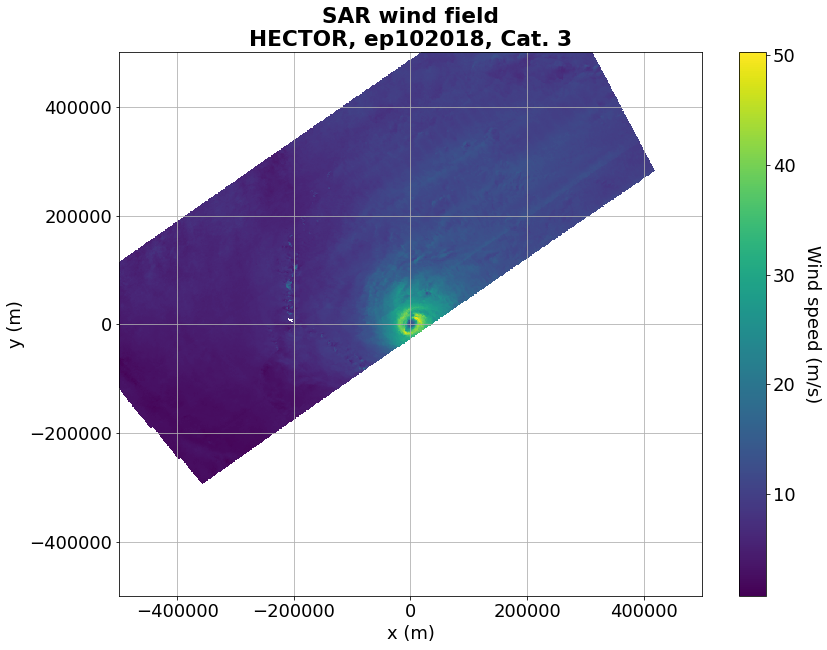

In [13]:
### FIND ALL TIME INDEXES FROM NAME AND PLOT ALL CORRESPONDING OBSERVATIONS
def find_time_idx(ds_all, storm_name):
    '''Given an xarray.Dataset object containing all the files (e.g 341) and a storm name (string), 
    returns a 1D array containing all the time indexes corresponding to the storm name in the global Dataset.'''
    return np.where(ds_all['storm_name']==storm_name)[0]

storm_name = 'HECTOR'
print('Indexes for %s: '%storm_name, find_time_idx(ds_all, storm_name))
for time_idx in find_time_idx(ds_all, storm_name):
    plot_wind_field(ds_all, time_idx)

In [14]:
### GROUP DATASET BY CATEGORY
for cat, ds_cat in ds_all.groupby('cat'):
    print('Cat. %i ='%cat, ds_cat.dims['time'])

Cat. 0 = 92
Cat. 1 = 82
Cat. 2 = 41
Cat. 3 = 55
Cat. 4 = 54
Cat. 5 = 17


In [17]:
### TOOLS TO INTERPOLATE DATASET ON (R*, TH) SCALE
from scipy.signal import convolve2d

def cart2pol(x, y):
    r  = np.sqrt(x**2 + y**2)
    th = np.arctan2(y, x)
    return r, th

def compute_SAR_2D_Rmax_Vmax(ds):
    # Put zeros where NaNs and ones elsewhere
    ds_ws                    = np.asarray(ds['wind_speed'])
    ds_ones                  = np.ones(ds_ws.shape)
    ds_ones[np.isnan(ds_ws)] = 0.

    # Convolve this with a 10 x 10 kernel of ones to count the number of NaNs
    kernel                   = np.ones((10, 10))
    valid_counter            = convolve2d(ds_ones, kernel, mode='same')
    valid_counter           /= kernel.shape[0] * kernel.shape[1]

    # Set to NaN where threshold is exceeded
    thresh                        = 0.99
    ds_ws[valid_counter < thresh] = np.nan # if there is less than 99% (thresh = 0.99) of valid values, we set to nan 

    # Compute Rmax_SAR_2D and Vmax_SAR_2D
    idx_max                  = np.nanargmax(ds_ws)
    Vmax_SAR_2D              = np.reshape(np.asarray(ds_ws), -1)[idx_max]
    Rmax_SAR_2D              = np.reshape(np.asarray(ds['r']), -1)[idx_max]
    
    return Rmax_SAR_2D, Vmax_SAR_2D

# Concatenate samples only with Rmax < 150
n_total = len(ds_all['time'])
n_test  = 2
n       = n_test
for time_idx in tqdm(range(n)):
    # Assign polar coordinates to ds
    ds    = ds_all.isel(time=time_idx)
    r, th = cart2pol(ds['x'], ds['y'])
    ds    = ds.assign_coords({'r': r, 'th': th})
    
    # Compute Rmax/Vmax and concatenate
    Rmax, Vmax = compute_SAR_2D_Rmax_Vmax(ds)
    
    # # Concatenate
    # if round(Rmax_new / 1000) < 150:
    #     # TODO: add to dataset
    # else:
    #     # TODO: do not add to dataset

100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.25s/it]
